# Install required libraries quietly (without verbose output)


In [1]:
! pip install -q langgraph langchain-core langchain-community langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00


# Import necessary modules

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel

In [3]:
# Define a state model using Pydantic to enforce type constraints
class OverallState(BaseModel):
    a: str


# Define a function (node) that modifies the state
# It receives the current state and returns a new state with updated value
def node(state:OverallState):
  return {"a":"Hi i am saurav"} # Overrides 'a' with a new string

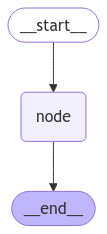

In [4]:
# Create a StateGraph object with the defined state model
builder = StateGraph(OverallState)

# Add a node to the graph and link it to the function
builder.add_node("node",node)

# Define the flow of execution in the graph
builder.add_edge(START,"node")
builder.add_edge("node",END)

# Compile the graph for execution
graph = builder.compile()
graph

In [5]:
# Invoke the graph with an initial state
graph.invoke({"a":"Hello"})

{'a': 'Hi i am saurav'}

In [6]:
# Try invoking the graph with an incorrect data type (integer instead of string)
try:
  graph.invoke({"a":1})
except Exception as e:
  print("Raised exception because a value is integer\n",e)

Raised exception because a value is integer
 1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Explaining
1. LangGraph applies validation when a node receives an input.
2. `bad_node` produces an invalid state ("a": 123), but this is not checked immediately.
3. When ok_node receives the bad state, it fails validation, causing an error.


# Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

# Import necessary libraries


In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel

In [8]:
# Define the overall state schema using Pydantic
class OverallState(BaseModel):
  a:str

# Define a node that incorrectly assigns an integer to 'a'
def bad_node(state:OverallState):
  return {
      "a":123
  }

# Define a node that correctly assigns a string to 'a'
def ok_node(state:OverallState):
  return {
      "a":"goobye"
  }

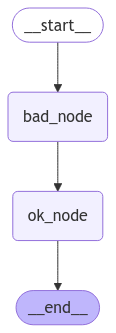

In [9]:
# Create a StateGraph object with the defined schema
builder = StateGraph(OverallState)

# Add nodes to the graph
builder.add_node("bad_node",bad_node)
builder.add_node("ok_node",ok_node)

# Define the flow of execution in the graph
builder.add_edge(START,"bad_node")
builder.add_edge("bad_node","ok_node")
builder.add_edge("ok_node",END)

# Compile the graph
graph = builder.compile()
graph

In [10]:
# Try running the graph with a valid initial state
try:
  graph.invoke({"a":"Hello"})
except Exception as e:
  # An error occurs because 'bad_node' outputs an integer instead of a string
  print(e)

1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Explanation:
1. **Schema Validation:** `OverallState` enforces that `a` should always be a string.
2. **Node Execution:**
   - `bad_node` wrongly assigns an integer (`123`) to `a`, violating the schema.
   - The validation doesn't fail immediately because `bad_node` itself is not checked.
   - The failure happens when `ok_node` tries to use the updated state and encounters an invalid type.
3. **Error Handling:** When the graph is invoked, a `ValidationError` is raised when `ok_node` receives the bad state.

Let me know if you need further refinements! 🚀

# Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

In [11]:
import os
from langchain_groq import ChatGroq
from google.colab import userdata
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [12]:
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [13]:
llm = ChatGroq(model="qwen-2.5-32b")

In [14]:
class State(TypedDict):
  topic:str
  joke:str
  improved_joke:str
  final_joke:str

In [15]:
def generate_joke(state:State):
  '''
  LLM call to generate initial joke
  '''
  msg = llm.invoke(f"Write a short joke about {state['topic']}")
  return {"joke":msg.content}


def check_punchline(state:State):
  '''
  check if the joke has a punchline
  '''
  if "?" in state["joke"] or "!" in state["joke"]:
    return "Fail"
  else:
    return "Pass"


def improve_joke(state:State):
  '''
  LLM call to improve the joke
  '''
  msg = llm.invoke(f"Improve the following joke by adding wordplay: {state['joke']}")
  return {"improved_joke":msg.content}


def polish_joke(state:State):
  '''
  LLM call for final polish
  '''
  msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
  return {"final_joke":msg.content}


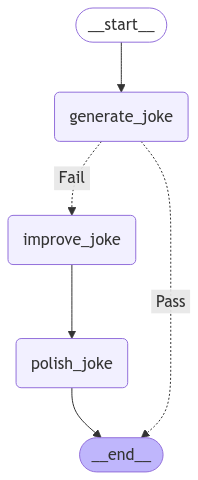

In [16]:
workflow = StateGraph(State)

workflow.add_node("generate_joke",generate_joke)
workflow.add_node("improve_joke",improve_joke)
workflow.add_node("polish_joke",polish_joke)

workflow.add_edge(START,"generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke","polish_joke")
workflow.add_edge("polish_joke",END)


graph = workflow.compile()
graph

In [17]:
graph.invoke({"topic":"cats"})

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'improved_joke': "Why don't cats play poker in the wild? Because every game gets clawsed when there are cheetahs afoot!",
 'final_joke': "Why don't cats play poker in the wild? Because every game gets clawsed when there are cheetahs afoot, especially when the cheetahs are actually expert card cheats, always dealing themselves the winning hand!"}

# Parallelization
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

In [18]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [19]:
class State(TypedDict):
  topic:str
  joke:str
  story:str
  poem:str
  combined_output:str


def generate_joke(state:State):
  '''
  LLM call to generate initial joke
  '''
  msg = llm.invoke(f"Write a short joke about {state['topic']}")
  return {"joke":msg.content}

def generate_story(state:State):
  '''
  LLM call to generate initial story
  '''
  msg = llm.invoke(f"Write a short story about {state['topic']}")
  return {"story":msg.content}

def generate_poem(state:State):
  '''
  LLM call to generate initial poem
  '''
  msg = llm.invoke(f"Write a short poem about {state['topic']}")
  return {"poem":msg.content}

def aggregator(state:State):
  '''
  Combine the joke, story and poem into a single output
  '''
  combined = f"Here's a story, joke and poem about {state['topic']}\n\n"
  combined += f"Story: {state['story']}\n\n"
  combined += f"Joke: {state['joke']}\n\n"
  combined += f"Poem: {state['poem']}\n\n"
  return {"combined_output":combined}


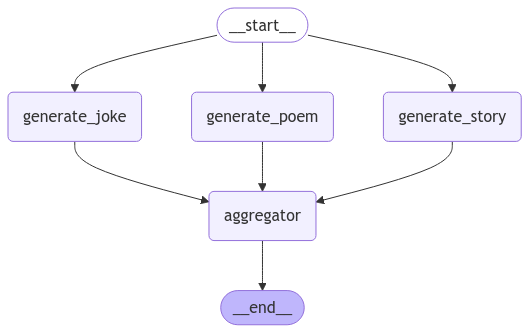

In [20]:
parallel_builder = StateGraph(State)

parallel_builder.add_node("generate_joke",generate_joke)
parallel_builder.add_node("generate_story",generate_story)
parallel_builder.add_node("generate_poem",generate_poem)
parallel_builder.add_node("aggregator",aggregator)

parallel_builder.add_edge(START,"generate_joke")
parallel_builder.add_edge(START,"generate_story")
parallel_builder.add_edge(START,"generate_poem")

parallel_builder.add_edge("generate_joke","aggregator")
parallel_builder.add_edge("generate_story","aggregator")
parallel_builder.add_edge("generate_poem","aggregator")

parallel_builder.add_edge("aggregator",END)

parallel_graph = parallel_builder.compile()
parallel_graph

In [21]:
parallel_graph.invoke({"topic":"cats"})

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'story': 'In the quiet little town of Willowbrook, nestled between sprawling forests and a serene river, there lived a group of cats who were as much a part of the town\'s charm as its picturesque landscapes. These weren\'t your average cats. They were known for their adventurous spirits and peculiar behaviors, which often left the townsfolk with stories to tell.\n\nAmong them was a black cat named Midnight, who was known for her mysterious ways. Midnight would often disappear for days, only to return with tales of far-off lands, spun from the whispers of the wind. The townsfolk, who were used to her stories, would gather around her, their eyes wide with wonder.\n\nOne sunny afternoon, as the heat of the day was settling, Midnight gathered her friends: Fluffy, a white cat with a heart of gold; Stripe, a sleek silver cat with stripes as bold as his personality; and Whiskers, a smal

# Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

# Import necessary libraries

In [22]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [23]:
# Define a data model for routing decisions
class Route(BaseModel):
  step: Literal["poem","story","joke"] = Field(
      None, description="The next step in the routing process"
  )

In [24]:
# Create an LLM-based router that determines the type of content requested
router = llm.with_structured_output(Route)
router # This router will classify input into "poem", "story", or "joke"

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7b23678a9650>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7b2367626e90>, model_name='qwen-2.5-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Route', 'description': '', 'parameters': {'properties': {'step': {'default': None, 'description': 'The next step in the routing process', 'enum': ['poem', 'story', 'joke'], 'type': 'string'}}, 'type': 'object'}}}], 'structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'Route', 'description': '', 'parameters': {'properties': {'step': {'default': None, 'description': 'The next step in the routing process', 'enum': ['poem', 'story', 'joke'], 'type': 'string'}}, 'type': 'object'}}}}, 'tool_choice': {'type': 'function', 'function': {'name': 'Route'}}}, config={}, config_factories=[])
|

In [25]:
# Define the state of the workflow
class State(TypedDict):
  input:str # User input text
  decision:str # The routing decision made by LLM
  output:str # The generated output (story, joke, or poem)

# Function to generate a story based on user input
def generate_story(state:State):
  '''Write a story'''
  result = llm.invoke(state["input"])
  return {"output":result.content}


# Function to generate a joke based on user input
def generate_joke(state:State):
  '''Write a joke'''
  result = llm.invoke(state["input"])
  return {"output":result.content}

# Function to generate a poem based on user input
def generate_poem(state:State):
  '''Write a poem'''
  result = llm.invoke(state["input"])
  return {"output":result.content}


# Function to route the input to the appropriate function
def llm_call_route(state:State):
  '''Route the input to the appropriate function'''
  decision = router.invoke(
      [
          SystemMessage(
              content="Route the input to story, joke, or poem based on user request"
          ),
          HumanMessage(
              content = state['input']
          )
      ]
  )
  return {"decision":decision.step} # Return the decision made by the router


# Function to determine which function to call based on routing decision
def route_decision(state:State):
  if state["decision"] == "story":
    return "generate_story"
  elif state["decision"] == "joke":
    return "generate_joke"
  elif state["decision"] == "poem":
    return "generate_poem"

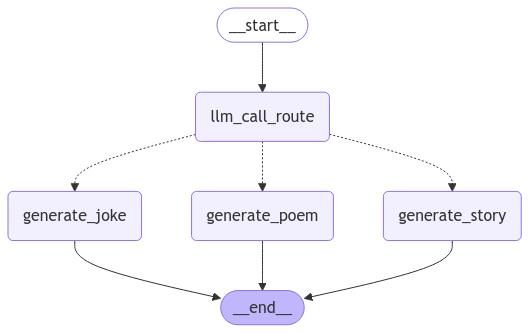

In [26]:
# Create a workflow graph using LangGraph
router_builder = StateGraph(State)

# Add nodes (functions) to the workflow
router_builder.add_node("llm_call_route",llm_call_route) # Decision node
router_builder.add_node("generate_story",generate_story)
router_builder.add_node("generate_joke",generate_joke)
router_builder.add_node("generate_poem",generate_poem)

# Define the workflow execution path
router_builder.add_edge(START,"llm_call_route")

# Add conditional edges to route execution to the correct function
router_builder.add_conditional_edges(
    "llm_call_route",
    route_decision, # Function that decides which path to take
    {
        "generate_story":"generate_story",
        "generate_joke":"generate_joke",
        "generate_poem":"generate_poem"
    }
)
router_builder.add_edge("generate_story",END)
router_builder.add_edge("generate_joke",END)
router_builder.add_edge("generate_poem",END)

# Compile the workflow graph
router_graph = router_builder.compile()
router_graph

In [27]:
# Invoke the workflow with an example input
router_graph.invoke({"input":"Write a poem about cats"})

{'input': 'Write a poem about cats',
 'decision': 'poem',
 'output': "In the twilight's gentle embrace,\nSilent shadows glide with grace,\nFeline figures, lithe and sleek,\nWhiskers twitch in dreams they seek.\n\nEyes like lanterns, amber bright,\nThrough the night they pierce the light,\nPaws that pad with silent ease,\nIn the calm, their hunter's tease.\n\nMajestic lords of secret places,\nTales of magic in their faces,\nFrom the heights of sunlit beams,\nTo the whispering shadows' dreams.\n\nPurring motors, soft and low,\nComfort's voice in tones they know,\nLives of mystery and delight,\nIn each furry creature's sight.\n\nSo here's to tails that twist and curl,\nAnd the tales that cats unfurl,\nGuardians, mischief-makers, wise,\nEver in our hearts, they prize."}

## **🔹 Final Workflow Execution Path**
1️⃣ **User provides input** → `"Write a poem about cats"`  
2️⃣ **Routing function determines the category** (`poem`, `story`, or `joke`)  
3️⃣ **Workflow follows the appropriate execution path**:
   - If `"poem"` → Calls `generate_poem`
   - If `"story"` → Calls `generate_story`
   - If `"joke"` → Calls `generate_joke`  
4️⃣ **LLM generates the output**  
5️⃣ **Execution ends, returning the generated content**

# Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

In [28]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [29]:
# Define the state dictionary to track joke generation, feedback, and evaluation
class State(TypedDict):
  joke: str  # Stores the generated joke
  topic: str  # Stores the topic for joke generation
  feedback: str  # Stores feedback for improving the joke
  funny_or_not: str  # Stores evaluation result ('funny' or 'not funny')


# Define the evaluation output model
class Feedback(BaseModel):
  grade: Literal["funny","not funny"] = Field(
      description="Decide if the joke is funny or not."
  )

  feedback:str = Field(
      description="If the joke is not funny, Provide feedback on the joke to improve it."
  )

# Initialize the evaluator, which will classify the joke as 'funny' or 'not funny' and provide feedback
evaluator = llm.with_structured_output(Feedback)
evaluator

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7b23678a9650>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7b2367626e90>, model_name='qwen-2.5-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Feedback', 'description': '', 'parameters': {'properties': {'grade': {'description': 'Decide if the joke is funny or not.', 'enum': ['funny', 'not funny'], 'type': 'string'}, 'feedback': {'description': 'If the joke is not funny, Provide feedback on the joke to improve it.', 'type': 'string'}}, 'required': ['grade', 'feedback'], 'type': 'object'}}}], 'structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'Feedback', 'description': '', 'parameters': {'properties': {'grade': {'description': 'Decide if the joke is funny or not.', 'enum': ['funny', 'not funny'], 'type': 'string'}, 'fee

In [30]:
def llm_call_generator(state:State):
  '''LLM generates a joke'''
  if state.get("feedback"): # If feedback exists, refine the joke based on it
    msg = llm.invoke(f"Write a joke about {state['topic']} based on the following feedback: {state['feedback']}")
  else:
     # Generate a fresh joke without feedback
    msg = llm.invoke(f"Write a joke about {state['topic']}")
  return {"joke":msg.content}

def llm_call_evaluator(state:State):
  '''LLM evaluates the joke'''
  grade = evaluator.invoke(f"Grade the joke {state['joke']}")
  return {"funny_or_not":grade.grade,"feedback":grade.feedback} # Return classification and feedback



def route_joke(state:State):
  if state["funny_or_not"] == "funny":
    return "Accepted"  # If the joke is funny, accept and stop iteration
  elif state["funny_or_not"] == "not funny":
    return "Rejected + Feedback"  # If not funny, refine and retry

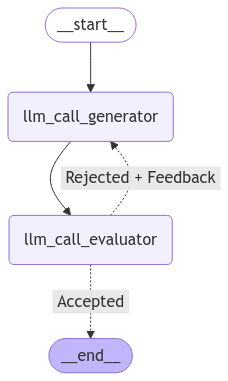

In [31]:
# Build the workflow graph
builder = StateGraph(State)

# Add nodes for joke generation and evaluation
builder.add_node("llm_call_generator",llm_call_generator)
builder.add_node("llm_call_evaluator",llm_call_evaluator)

# Define the workflow sequence
builder.add_edge(START,"llm_call_generator")
builder.add_edge("llm_call_generator","llm_call_evaluator")

# Define conditional branching based on evaluation result
builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted":END, # If the joke is funny, stop
        "Rejected + Feedback":"llm_call_generator"
    }
)

# Compile the graph
graph = builder.compile()
graph

In [32]:
# Run the workflow with an initial topic
graph.invoke({"topic":"cats"})

{'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'topic': 'cats',
 'feedback': 'The joke is playful and uses wordplay effectively.',
 'funny_or_not': 'funny'}

### Explanation of the Code:
1. **State Definition**:
   - A `TypedDict` named `State` keeps track of joke generation, feedback, and evaluation.

2. **Evaluation Model**:
   - `Feedback` class uses Pydantic to structure LLM responses with:
     - `grade`: Classifies the joke as `"funny"` or `"not funny"`.
     - `feedback`: If `"not funny"`, it provides suggestions for improvement.

3. **Joke Generation**:
   - `llm_call_generator` generates a joke based on the given `topic` and refines it if previous feedback exists.

4. **Joke Evaluation**:
   - `llm_call_evaluator` grades the joke and provides feedback if necessary.

5. **Routing Logic**:
   - `route_joke` determines if the joke is funny or needs improvement.

6. **Workflow Structure**:
   - The graph begins with joke generation.
   - The joke is evaluated.
   - If funny, the process stops.
   - If not, the joke is regenerated using feedback, looping until an acceptable joke is produced.